In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geocoder
import requests
import time

In [3]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
CSV_PATH = os.path.join('data', 'hacknight_ticket_sample_data_2015.csv')
df = pd.read_csv(CSV_PATH,low_memory=False, parse_dates=['issue_date', 'ticket_queue_date'])

In [5]:
df.head()

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,unit_description,vehicle_make,fine_level1_amount,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address
0,9188814621,2015-05-07 13:52:00,2134 S ARCHER AV,7c189a16ef79db9413c1f46b7e5d1712e5c0c1575be352...,MI,PAS,48103,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,BUIC,50,100,0.0,50.0,Paid,2015-05-13,NaN,NaN,0,798,"2100 s archer av, chicago, il"
1,65543631,2015-01-10 17:09:00,423 N LARAMIE,13d93046fb2c3bc2d79baa8647d620d0c5a65fdc223cb9...,IL,PAS,606394357,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,15,CPD,CHRY,60,120,146.4,0.0,Notice,2015-01-28,SEIZ,NaN,5109291290,16391,"400 n laramie, chicago, il"
2,9188975267,2015-06-11 18:49:00,1338 W CORNELIA,265ee87ad9d24c7732f65383e6b9af1f344348bf639ce2...,IL,PAS,606134985,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,502,DOF,BMW,60,120,0.0,60.0,Paid,2015-06-23,VIOL,NaN,5190301770,1444,"1300 w cornelia, chicago, il"
3,64465302,2015-01-14 08:09:00,229 W CERMAK RD,2800f6eaba1dc6fde0b0785df17c808dba871d1570cc4c...,IL,PAS,605442187,0964130A,PARK ALLEY,495,Miscellaneous,HOND,150,300,0.0,150.0,Paid,2015-04-28,DETR,NaN,5191229940,313,"200 w cermak rd, chicago, il"
4,9189537354,2015-10-28 16:26:00,2410 N MONTICELLO AV,f0858c838c8cabda4e8fd3e0425a6c330a76e006f9de01...,IL,PAS,60625,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,729,Miscellaneous,TOYT,50,100,0.0,100.0,Paid,2016-01-27,SEIZ,NaN,5168404170,1407,"2400 n monticello av, chicago, il"


In [6]:
df['address'].head()

0        2100 s archer av, chicago, il
1           400 n laramie, chicago, il
2         1300 w cornelia, chicago, il
3         200 w cermak rd, chicago, il
4    2400 n monticello av, chicago, il
Name: address, dtype: object

In [7]:
addrs_df = pd.DataFrame(df['address'].str.split(',').tolist(), columns=['address', 'city', 'state'])
addrs_df.head()

,address,city,state
0,2100 s archer av,chicago,il
1,400 n laramie,chicago,il
2,1300 w cornelia,chicago,il
3,200 w cermak rd,chicago,il
4,2400 n monticello av,chicago,il


In [8]:
addrs_df['city'].unique()

array([' chicago'], dtype=object)

In [9]:
addrs_df['state'].unique()

array([' il'], dtype=object)

Ok, from these lists of unique values, we see the 'address' field was very clean and consistent. As we expect, the city was always Chicago and the state was always IL. 

Looking at the street numbers, it looks like addresses were truncated down to just their block.  From the count of unique addresses below, we see that on average, each address in this sample of the data got about 2.5 tickets.  As geocoding addresses is an expensive operation, I'll only geocode each address once, and then use an inner join later to add in latitude and longitude values for all addresses. 

In [10]:
print('Total number of entried:    {}'.format(len(addrs_df['address'])))
print('Number of unique addresses: {}'.format(len(addrs_df['address'].unique())))

Total number of entried:    50000
Number of unique addresses: 20608


In [11]:
df['address'].value_counts()

5700 s cicero, chicago, il               130
2100 s archer av, chicago, il             98
10000 w ohare, chicago, il                82
5000 w 55th st, chicago, il               69
1400 e 53rd st, chicago, il               67
1400 n milwaukee av, chicago, il          64
500 w madison st, chicago, il             64
100 w hubbard, chicago, il                60
4700 n lincoln av, chicago, il            54
1100 n state st, chicago, il              54
300 w erie st, chicago, il                53
1500 n milwaukee av, chicago, il          51
1100 s canal st, chicago, il              49
400 n state st, chicago, il               45
1 e oak st, chicago, il                   45
1 w randolph, chicago, il                 43
1300 n milwaukee av, chicago, il          43
5200 n clark st, chicago, il              43
5300 s lake park - inner, chicago, il     42
10000 w ohare e lot, chicago, il          41
1100 n state, chicago, il                 40
1000 w madison st, chicago, il            40
1500 e 53r

In [12]:
addrs_df = pd.DataFrame(addrs_df['address'].unique(), columns=['address'])
addrs_df['lat'] = np.nan
addrs_df['lng'] = np.nan
addrs_df.head()

,address,lat,lng
0,2100 s archer av,NaN,NaN
1,400 n laramie,NaN,NaN
2,1300 w cornelia,NaN,NaN
3,200 w cermak rd,NaN,NaN
4,2400 n monticello av,NaN,NaN


In [13]:
class GeoSessions:
    def __init__(self):
        self.Arcgis = requests.Session()
        self.Komoot = requests.Session()
        self.USCensus = requests.Session()
        self.OSM = requests.Session()

def create_sessions():
    return GeoSessions()

def geocode_address(address, s):
    g = geocoder.osm(address, session=s.OSM)
    if (g.ok == False):
        g = geocoder.komoot(address, session=s.Komoot)
    if (g.ok == False):
        g = geocoder.arcgis(address, session=s.Arcgis)
    if (g.ok == False):
        g = geocoder.uscensus(address, session=s.USCensus)
    return g

In [14]:
s = create_sessions()

In [15]:
addr = addrs_df['address'][0] + ', Chicago, IL'
tmp = geocode_address(addr, s)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

2100 s archer av, Chicago, IL
Latitude:  41.85455545
Longitude: -87.6322748875566


In [16]:
addr = addrs_df['address'][0] + ', Chicago, IL'
tmp = geocoder.uscensus(addr, session=s.USCensus)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

2100 s archer av, Chicago, IL
Latitude:  41.85358
Longitude: -87.63335


In [17]:
addr = addrs_df['address'][0] + ', Chicago, IL'
tmp = geocoder.komoot(addr, session=s.Komoot)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

2100 s archer av, Chicago, IL
Latitude:  41.85455545
Longitude: -87.63227488755658


In [18]:
addr = addrs_df['address'][0]
tmp = geocoder.tamu(location=addr, city='chicago', state='IL', session=s.TAMU, key='demo')
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

AttributeError: 'GeoSessions' object has no attribute 'TAMU'

In [ ]:
addr = addrs_df['address'][0] + ', Chicago, IL'
tmp = geocode_address(addr, s)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

In [ ]:
OUT_PATH = os.path.join('data', 'hacknight_sample_data_geocode.csv')
if os.path.isfile(OUT_PATH):
    addrs_df = pd.read_csv(OUT_PATH)
    print('It existed')
addrs_df.head()

In [20]:
failed_inds = []
iterations_between_saves = 100

I kept rerunning the cell below, waiting for something to blow up. Nothing blew up though. This geocoded about 100 addresses per minute, it didn't require an API key, and the geocoder documentation doesn't list any restrictions on the use of the data.

In [78]:
missing_latlong_indices = addrs_df[addrs_df['lat'].isnull()][:2001].index.tolist()

for i in missing_latlong_indices:
    try:
        if i%iterations_between_saves == 0:
            print('reached index {}, saving df'.format(i))
            addrs_df.to_csv(OUT_PATH, index=False)
        addr = addrs_df['address'][i] + ', Chicago, IL'
        tmp = geocode_address(addr, s)
        addrs_df.loc[i,'lat'] = tmp.lat
        addrs_df.loc[i,'lng'] = tmp.lng
    except Exception as e:
        failed_inds.append(i)
addrs_df.to_csv(OUT_PATH, index=False)

reached index 19800, saving df
reached index 19900, saving df
reached index 20000, saving df
reached index 20100, saving df
reached index 20200, saving df
reached index 20300, saving df
reached index 20400, saving df
reached index 20500, saving df
reached index 20600, saving df


In [86]:
addrs_df.to_csv(OUT_PATH, index=False)

In [24]:
addrs_df.iloc[-25:]

,address,lat,lng
20583,4300 s talman,41.815545,-87.690810
20584,2800 w cortez,41.900575,-87.696901
20585,3500 s bell,41.830372,-87.681430
20586,1600 n sedgwick,41.911148,-87.638639
20587,5700 s michigan ave,41.790842,-87.622408
20588,2700 w maypole,41.883677,-87.693992
20589,7200 s constance ave,41.764226,-87.580604
20590,2800 e 77th pl,41.754561,-87.555020
20591,3400 s prairie,41.832746,-87.620598
20592,10400 s calumet,41.705333,-87.614970


In [80]:
failed_inds

[]

In [19]:
addrs_df['address'] = addrs_df['address'] + ', chicago, il'

In [20]:
geocoded_df = pd.merge(left=df, right=addrs_df, how='inner', on='address')
geocoded_df.head()

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,unit_description,vehicle_make,fine_level1_amount,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address,lat,lng
0,9188814621,2015-05-07 13:52:00,2134 S ARCHER AV,7c189a16ef79db9413c1f46b7e5d1712e5c0c1575be352...,MI,PAS,48103,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,BUIC,50,100,0.0,50.0,Paid,2015-05-13,NaN,NaN,0,798,"2100 s archer av, chicago, il",NaN,NaN
1,9188417037,2015-01-01 21:29:00,2167 S ARCHER AV,ac7f6f4be49dfa223571838e586653aa5cdcb6bdfc6385...,IL,PAS,NaN,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,502,DOF,MITS,50,100,0.0,50.0,Paid,2015-01-05,NaN,NaN,0,1529,"2100 s archer av, chicago, il",NaN,NaN
2,9188598734,2015-03-26 13:14:00,2140 S ARCHER AV,a493850f62c8ca5a25787271859f0409c289fb84130f33...,OH,PAS,45409,0976160A,REAR AND FRONT PLATE REQUIRED,498,DOF,PORS,60,120,146.4,0.0,Notice,2015-04-08,SEIZ,NaN,5191566530,780,"2100 s archer av, chicago, il",NaN,NaN
3,9189154639,2015-07-24 14:18:00,2172 S ARCHER AV,38a1ef0c0a325c79e9dba69f6e96652fcbf1e9dcb5db3f...,IL,PAS,606161514,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,MERZ,50,100,0.0,0.0,Dismissed,2015-09-14,VIOL,Not Liable,5176435360,796,"2100 s archer av, chicago, il",NaN,NaN
4,9188041623,2015-01-17 14:45:00,2107 S ARCHER AV,e3c39cce6c30735cc977656a463233ea6f516328828e8d...,LA,PAS,70072,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,502,DOF,HOND,50,100,122.0,0.0,Notice,2015-02-04,SEIZ,NaN,5181845840,1461,"2100 s archer av, chicago, il",NaN,NaN


In [21]:
df['issue_date'].max()

Timestamp('2015-12-31 23:40:00')

In [22]:
# How many tickets did each officer (left column) write?
df['officer'].value_counts()

728      429
716      404
638      331
765      326
723      325
737      314
1385     296
790      282
690      281
800      279
1444     274
287      271
714      262
772      261
761      260
641      256
1374     256
735      256
746      253
102      250
776      231
1529     231
1491     228
789      223
1462     220
657      219
187      219
1457     217
754      214
797      214
        ... 
01064      1
7446       1
12812      1
4665       1
14410      1
10266      1
6985       1
18563      1
X9672      1
15184      1
15939      1
12364      1
7886       1
5531       1
19693      1
19771      1
13191      1
5610       1
4890       1
12177      1
04094      1
18402      1
13587      1
11969      1
6253       1
4052       1
9405       1
14229      1
6917       1
5495       1
Name: officer, Length: 5779, dtype: int64

C:\Users\mattt\Anaconda3\envs\ds36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


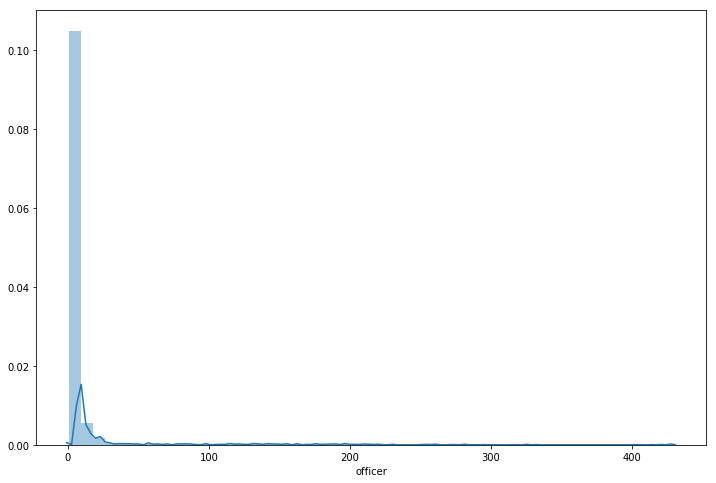

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(df['officer'].value_counts(), ax=ax)

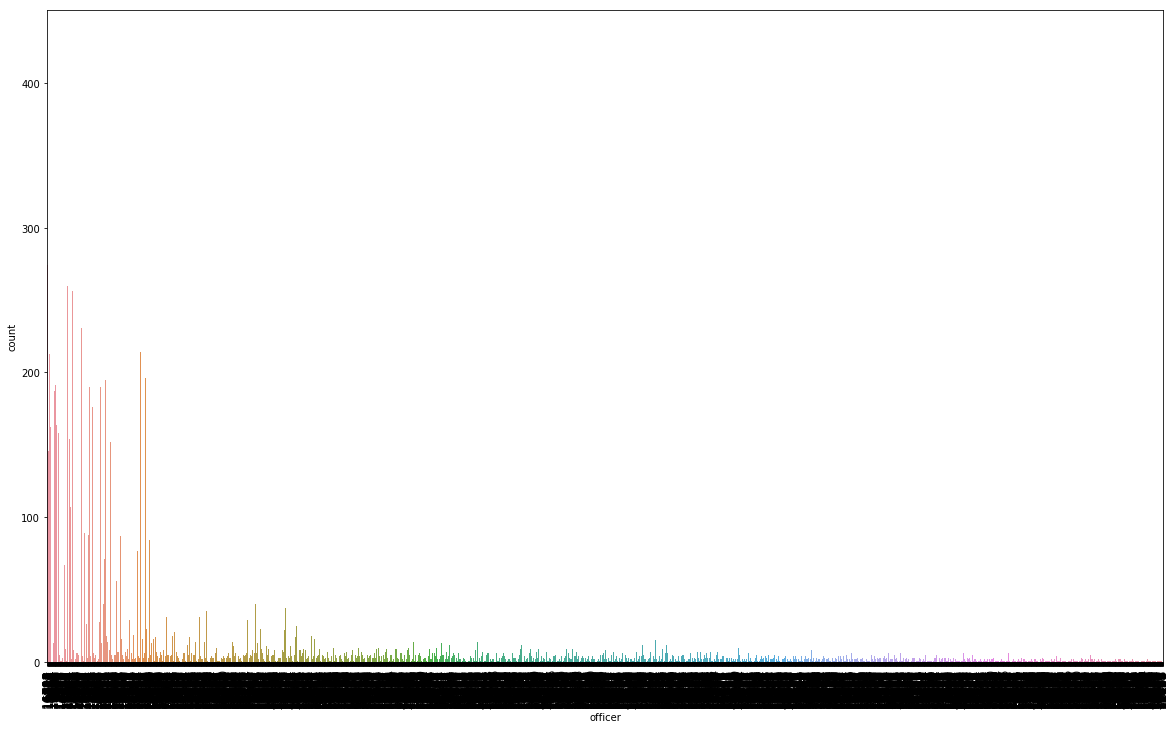

In [68]:
fig, ax = plt.subplots(figsize=(20,12))
sns.countplot(df['officer'], ax=ax)
ax.axes.xaxis.set_tick_params(rotation=90, labelsize=12)

(array([5.581e+03, 4.800e+01, 3.700e+01, 4.400e+01, 4.100e+01, 1.300e+01,
        9.000e+00, 4.000e+00, 0.000e+00, 2.000e+00]),
 array([  1. ,  43.8,  86.6, 129.4, 172.2, 215. , 257.8, 300.6, 343.4,
        386.2, 429. ]),
 <a list of 10 Patch objects>)

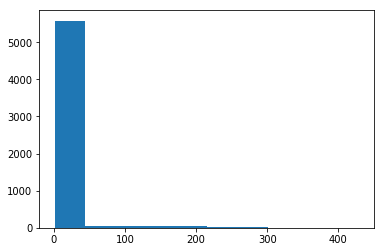

In [32]:
plt.hist(df['officer'].value_counts())

In [64]:
# geocoded_df[geocoded_df['officer'] == '728']

In [62]:
import folium
from folium.plugins import FastMarkerCluster

In [83]:
latitude = 41.8
longitude = -87.7
chi_map = folium.Map(location=[latitude, longitude], zoom_start=10)

subset_df = geocoded_df[geocoded_df['officer'] == '728']

chi_map.add_child(FastMarkerCluster(subset_df[['lat', 'lng']].values.tolist()))
chi_map

In [23]:
import geopandas as gpd
from shapely.geometry import Point

In [27]:
CSV_PATH = os.path.join('data', 'hacknight_sample_data_geocode.csv')
addrs_df = pd.read_csv(CSV_PATH)
addrs_df['address'] = addrs_df['address'] + ', chicago, il'
geocoded_df = pd.merge(left=df, right=addrs_df, how='inner', on='address')
geocoded_df.head()

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,unit_description,vehicle_make,fine_level1_amount,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address,lat,lng
0,9188814621,2015-05-07 13:52:00,2134 S ARCHER AV,7c189a16ef79db9413c1f46b7e5d1712e5c0c1575be352...,MI,PAS,48103,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,BUIC,50,100,0.0,50.0,Paid,2015-05-13,NaN,NaN,0,798,"2100 s archer av, chicago, il",41.854262,-87.631986
1,9188417037,2015-01-01 21:29:00,2167 S ARCHER AV,ac7f6f4be49dfa223571838e586653aa5cdcb6bdfc6385...,IL,PAS,NaN,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,502,DOF,MITS,50,100,0.0,50.0,Paid,2015-01-05,NaN,NaN,0,1529,"2100 s archer av, chicago, il",41.854262,-87.631986
2,9188598734,2015-03-26 13:14:00,2140 S ARCHER AV,a493850f62c8ca5a25787271859f0409c289fb84130f33...,OH,PAS,45409,0976160A,REAR AND FRONT PLATE REQUIRED,498,DOF,PORS,60,120,146.4,0.0,Notice,2015-04-08,SEIZ,NaN,5191566530,780,"2100 s archer av, chicago, il",41.854262,-87.631986
3,9189154639,2015-07-24 14:18:00,2172 S ARCHER AV,38a1ef0c0a325c79e9dba69f6e96652fcbf1e9dcb5db3f...,IL,PAS,606161514,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,MERZ,50,100,0.0,0.0,Dismissed,2015-09-14,VIOL,Not Liable,5176435360,796,"2100 s archer av, chicago, il",41.854262,-87.631986
4,9188041623,2015-01-17 14:45:00,2107 S ARCHER AV,e3c39cce6c30735cc977656a463233ea6f516328828e8d...,LA,PAS,70072,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,502,DOF,HOND,50,100,122.0,0.0,Notice,2015-02-04,SEIZ,NaN,5181845840,1461,"2100 s archer av, chicago, il",41.854262,-87.631986


In [43]:
western_point = geocoded_df[geocoded_df['lng'] < -88]
western_point.shape

(37, 25)

In [36]:
def geocode_address(address, s):
    g = geocoder.osm(address, session=s.OSM)
    if (g.ok == False):
        g = geocoder.komoot(address, session=s.Komoot)
    if (g.ok == False):
        g = geocoder.arcgis(address, session=s.Arcgis)
    if (g.ok == False):
        g = geocoder.uscensus(address, session=s.USCensus)
    return g

s = create_sessions()

In [44]:
for ind in western_point.index:
    tmp = geocode_address(geocoded_df.loc[ind, 'address'], s)
    geocoded_df.loc[ind, 'lat'] = tmp.lat
    geocoded_df.loc[ind, 'lng'] = tmp.lng

Status code Unknown from http://photon.komoot.de/api: ERROR - HTTPConnectionPool(host='photon.komoot.de', port=80): Read timed out. (read timeout=5.0)
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=1600+n+lsd%2C+chicago%2C+il&format=jsonv2&addressdetails=1&limit=1 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002528DD2F5C0>: Failed to establish a new connection: [WinError 10051] A socket operation was attempted to an unreachable network',))


In [46]:
western_point = geocoded_df[geocoded_df['lng'] < -88]
western_point.shape

(8, 25)

In [47]:
western_point

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,unit_description,vehicle_make,fine_level1_amount,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address,lat,lng
6311,9189764378,2015-12-18 14:05:00,2701 S PRAIRIE,ab214bfcae47665941b3cdc6270e6c6b038f1d227536ae...,IL,PAS,629012249,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,498,DOF,HOND,60,120,146.4,0.0,Notice,2015-12-24,SEIZ,NaN,5170191190,804,"2700 s prairie, chicago, il",41.890250,-88.223094
6312,9188713891,2015-04-21 08:58:00,2766 S PRAIRIE,ad692c84ea211c7261155c7811a474d26402ebb6fc6ebc...,IL,PAS,606162845,0964125B,"NO CITY STICKER VEHICLE UNDER/EQUAL TO 16,000 ...",498,DOF,HOND,200,400,0.0,200.0,Paid,2015-05-11,VIOL,NaN,5183286700,119,"2700 s prairie, chicago, il",41.890250,-88.223094
6313,66365360,2015-09-23 09:20:00,2711 S PRAIRIE,0cc1a6c217751816cdfd508259abc8a2c5af5e4c9510c5...,IL,PAS,60616,0964040B,STREET CLEANING,1,CPD,CADI,60,120,0.0,60.0,Paid,2015-10-22,VIOL,NaN,5194298820,10246,"2700 s prairie, chicago, il",41.890250,-88.223094
6314,9188385995,2015-01-22 07:58:00,2736 S PRAIRIE,2c2ad812f638b0ead87b019f1a8039f5e2f85585388419...,IL,PAS,606202111,0964090E,RESIDENTIAL PERMIT PARKING,498,DOF,CHEV,75,150,0.0,75.0,Paid,2015-03-26,DETR,NaN,5176360180,125,"2700 s prairie, chicago, il",41.890250,-88.223094
6315,65701164,2015-04-24 12:00:00,2700 S PRAIRIE,93f9cd9f3d4688e44fc64833fd146f3a96ba1c69cb563c...,IL,PAS,604523173,0976160A,REAR AND FRONT PLATE REQUIRED,1,CPD,MITS,60,120,0.0,0.0,Dismissed,2015-09-25,VIOL,Not Liable,5127499350,19920,"2700 s prairie, chicago, il",41.890250,-88.223094
13679,66151681,2015-07-28 04:10:00,911 E 130T PL,2c70feeaf7c6a27d869a241cbef82e5f4301c735f436d8...,IL,PAS,60827,0964125B,"NO CITY STICKER VEHICLE UNDER/EQUAL TO 16,000 ...",5,CPD,BUIC,200,400,488.0,0.0,Notice,2017-10-02,DLS,NaN,5021767690,4070,"900 e 130t pl, chicago, il",41.049782,-88.098118
43852,9189542007,2015-12-21 13:09:00,5338 W VETERANS PRKW,daec933dacb568aa663af22263ce2d79e4e060b849ecfa...,IL,PAS,606411727,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,AUDI,50,100,0.0,100.0,Paid,2016-03-18,FINL,NaN,5195810920,790,"5300 w veterans prkw, chicago, il",39.091988,-88.537995
48588,65517773,2015-01-12 14:31:00,5347 W VERTERANS PKWY,76f8b6e55196b7894b2ea10450e9f53aed7b6974de9948...,IL,PAS,60641,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,NISS,50,100,122.0,0.0,Notice,2015-02-04,SEIZ,NaN,5146608370,653,"5300 w verterans pkwy, chicago, il",39.091988,-88.537995


In [48]:
geocoded_df.loc[western_point.index]

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,unit_description,vehicle_make,fine_level1_amount,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address,lat,lng
6311,9189764378,2015-12-18 14:05:00,2701 S PRAIRIE,ab214bfcae47665941b3cdc6270e6c6b038f1d227536ae...,IL,PAS,629012249,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,498,DOF,HOND,60,120,146.4,0.0,Notice,2015-12-24,SEIZ,NaN,5170191190,804,"2700 s prairie, chicago, il",41.890250,-88.223094
6312,9188713891,2015-04-21 08:58:00,2766 S PRAIRIE,ad692c84ea211c7261155c7811a474d26402ebb6fc6ebc...,IL,PAS,606162845,0964125B,"NO CITY STICKER VEHICLE UNDER/EQUAL TO 16,000 ...",498,DOF,HOND,200,400,0.0,200.0,Paid,2015-05-11,VIOL,NaN,5183286700,119,"2700 s prairie, chicago, il",41.890250,-88.223094
6313,66365360,2015-09-23 09:20:00,2711 S PRAIRIE,0cc1a6c217751816cdfd508259abc8a2c5af5e4c9510c5...,IL,PAS,60616,0964040B,STREET CLEANING,1,CPD,CADI,60,120,0.0,60.0,Paid,2015-10-22,VIOL,NaN,5194298820,10246,"2700 s prairie, chicago, il",41.890250,-88.223094
6314,9188385995,2015-01-22 07:58:00,2736 S PRAIRIE,2c2ad812f638b0ead87b019f1a8039f5e2f85585388419...,IL,PAS,606202111,0964090E,RESIDENTIAL PERMIT PARKING,498,DOF,CHEV,75,150,0.0,75.0,Paid,2015-03-26,DETR,NaN,5176360180,125,"2700 s prairie, chicago, il",41.890250,-88.223094
6315,65701164,2015-04-24 12:00:00,2700 S PRAIRIE,93f9cd9f3d4688e44fc64833fd146f3a96ba1c69cb563c...,IL,PAS,604523173,0976160A,REAR AND FRONT PLATE REQUIRED,1,CPD,MITS,60,120,0.0,0.0,Dismissed,2015-09-25,VIOL,Not Liable,5127499350,19920,"2700 s prairie, chicago, il",41.890250,-88.223094
13679,66151681,2015-07-28 04:10:00,911 E 130T PL,2c70feeaf7c6a27d869a241cbef82e5f4301c735f436d8...,IL,PAS,60827,0964125B,"NO CITY STICKER VEHICLE UNDER/EQUAL TO 16,000 ...",5,CPD,BUIC,200,400,488.0,0.0,Notice,2017-10-02,DLS,NaN,5021767690,4070,"900 e 130t pl, chicago, il",41.049782,-88.098118
43852,9189542007,2015-12-21 13:09:00,5338 W VETERANS PRKW,daec933dacb568aa663af22263ce2d79e4e060b849ecfa...,IL,PAS,606411727,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,AUDI,50,100,0.0,100.0,Paid,2016-03-18,FINL,NaN,5195810920,790,"5300 w veterans prkw, chicago, il",39.091988,-88.537995
48588,65517773,2015-01-12 14:31:00,5347 W VERTERANS PKWY,76f8b6e55196b7894b2ea10450e9f53aed7b6974de9948...,IL,PAS,60641,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,498,DOF,NISS,50,100,122.0,0.0,Notice,2015-02-04,SEIZ,NaN,5146608370,653,"5300 w verterans pkwy, chicago, il",39.091988,-88.537995


In [40]:
out_df = geocoded_df[['address', 'lat', 'lng']]

In [41]:
OUT_PATH = os.path.join('data', 'hacknight_sample_data_geocode_cleaned.csv')
out_df.to_csv(OUT_PATH, index=False)

,address,lat,lng
0,"2100 s archer av, chicago, il",41.854262,-87.631986
1,"400 n laramie, chicago, il",41.887918,-87.755411
2,"1300 w cornelia, chicago, il",41.945332,-87.661621
3,"200 w cermak rd, chicago, il",41.852951,-87.632015
4,"2400 n monticello av, chicago, il",41.924665,-87.718253
